# Pruning

We will practice pruning using `tensorflow_model_optimization` class

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 42
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)

2025-08-08 07:34:48.935980: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-08 07:34:49.757471: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load the jet tagging dataset

In [2]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.models import load_model

## Load the pre-trained model
The model is trained with jet-tagging open datase: `hls4ml_lhc_jets_hlf`.

We used 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use relu activation. Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

Look at the **training notebook** to see the details:
https://github.com/ml4fp/2024-lbnl/blob/main/efficient_ml/part1_karas_training.ipynb

In [4]:
model = load_model('baseline_model/KERAS_check_best_model.h5')

2025-08-08 07:34:52.113766: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37098 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


## Train the pruned model

In [5]:
!pip install tensorflow_model_optimization

Defaulting to user installation because normal site-packages is not writeable


In [6]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruned_model = Sequential()
pruned_model.add(Dense(64, input_shape=(16,), name="fc1", kernel_initializer="lecun_uniform", kernel_regularizer=l1(0.0001)))
pruned_model.add(Activation(activation="relu", name="relu1"))
pruned_model.add(Dense(32, name="fc2", kernel_initializer="lecun_uniform", kernel_regularizer=l1(0.0001)))
pruned_model.add(Activation(activation="relu", name="relu2"))
pruned_model.add(Dense(32, name="fc3", kernel_initializer="lecun_uniform", kernel_regularizer=l1(0.0001)))
pruned_model.add(Activation(activation="relu", name="relu3"))
pruned_model.add(Dense(5, name="output", kernel_initializer="lecun_uniform", kernel_regularizer=l1(0.0001)))
pruned_model.add(Activation(activation="softmax", name="softmax"))

pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
pruned_model = prune.prune_low_magnitude(pruned_model, **pruning_params)

In [7]:
adam = Adam(learning_rate=0.0001)
pruned_model.compile(optimizer=adam, loss=["categorical_crossentropy"], metrics=["accuracy"])
callbacks = all_callbacks(
    stop_patience=1000,
    lr_factor=0.5,
    lr_patience=10,
    lr_epsilon=0.000001,
    lr_cooldown=2,
    lr_minimum=0.0000001,
    outputDir="pruned_model",
)
callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
pruned_model.fit(
    X_train_val,
    y_train_val,
    batch_size=1024,
    epochs=30,
    validation_split=0.25,
    shuffle=True,
    callbacks=callbacks.callbacks,
    verbose=0,
)
# Save the model again but with the pruning 'stripped' to use the regular layer types
pruned_model = strip_pruning(pruned_model)
pruned_model.save("pruned_model/model_best.h5")

2025-08-08 07:34:59.877567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-08-08 07:35:00.037655: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f3ea45987e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-08 07:35:00.037687: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2025-08-08 07:35:00.077670: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-08 07:35:00.206209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2025-08-08 07:35:00.430154: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro


***callbacks***
saving losses to pruned_model/losses.log

Epoch 1: val_loss improved from inf to 1.14899, saving model to pruned_model/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 1.14899, saving model to pruned_model/KERAS_check_best_model_weights.h5

Epoch 1: saving model to pruned_model/KERAS_check_model_last.h5

Epoch 1: saving model to pruned_model/KERAS_check_model_last_weights.h5

***callbacks end***


***callbacks***
saving losses to pruned_model/losses.log

Epoch 2: val_loss improved from 1.14899 to 1.00498, saving model to pruned_model/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 1.14899 to 1.00498, saving model to pruned_model/KERAS_check_best_model_weights.h5

Epoch 2: saving model to pruned_model/KERAS_check_model_last.h5

Epoch 2: saving model to pruned_model/KERAS_check_model_last_weights.h5

***callbacks end***


***callbacks***
saving losses to pruned_model/losses.log

Epoch 3: val_loss improved from 1.00498 to 0.93524, saving model 

## Check sparsity

Make a quick check that the model was indeed trained sparse. We’ll just make a histogram of the weights of the 1st layer, and hopefully observe a large peak in the bin containing ‘0’. Note logarithmic y axis.



Sparsity of unpruned model layer 1: 0.0% zeros
Sparsity of pruned model layer 1: 75.0% zeros


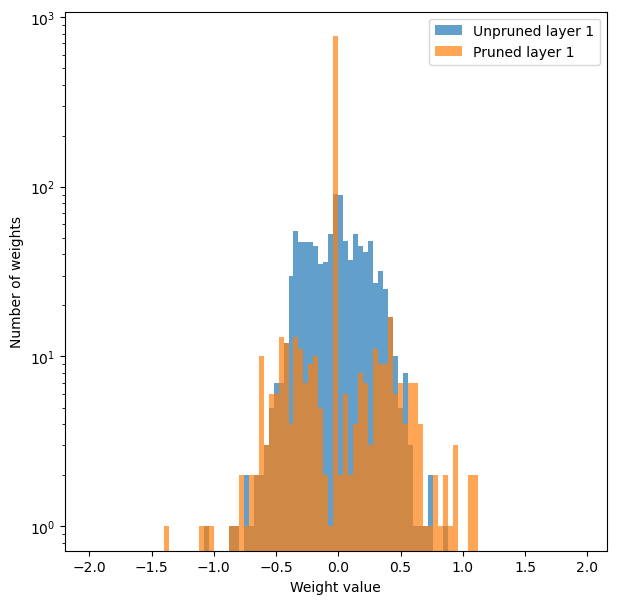

In [8]:
bins = np.arange(-2, 2, 0.04)
w_unpruned = model.layers[0].weights[0].numpy().flatten()
w_pruned = pruned_model.layers[0].weights[0].numpy().flatten()

plt.figure(figsize=(7, 7))

plt.hist(w_unpruned, bins=bins, alpha=0.7, label="Unpruned layer 1")
plt.hist(w_pruned, bins=bins, alpha=0.7, label="Pruned layer 1")

plt.xlabel("Weight value")
plt.ylabel("Number of weights")
plt.semilogy()
plt.legend()

print(f"Sparsity of unpruned model layer 1: {np.sum(w_unpruned==0)*100/np.size(w_unpruned)}% zeros")
print(f"Sparsity of pruned model layer 1: {np.sum(w_pruned==0)*100/np.size(w_pruned)}% zeros")
plt.show()


## Check performance
How does this 75% sparse model compare against the unpruned model? Let’s report the accuracy and make a ROC curve. The pruned model is shown with solid lines, the unpruned model is shown with dashed lines.

In [9]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

unpruned_model = load_model("baseline_model/KERAS_check_best_model.h5")

y_ref = unpruned_model.predict(X_test, verbose=0)
y_prune = pruned_model.predict(X_test, verbose=0)

print("Accuracy unpruned: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned:   {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune, axis=1))))

Accuracy unpruned: 0.7503734939759036
Accuracy pruned:   0.7418734939759036


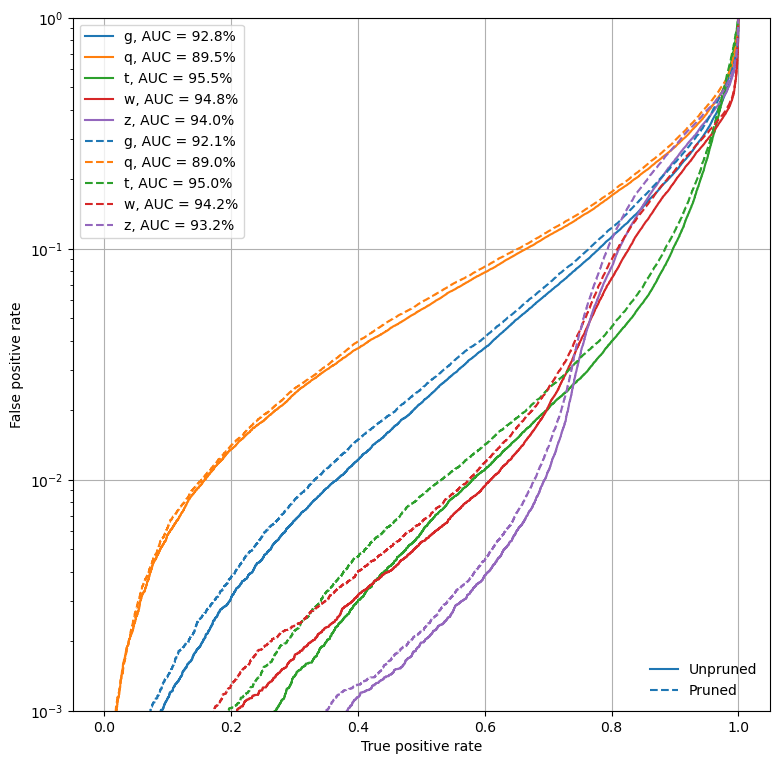

In [10]:
fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.make_roc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.make_roc(y_test, y_prune, classes, linestyle="--")

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls="-"), Line2D([0], [0], ls="--")]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=["Unpruned", "Pruned"], loc="lower right", frameon=False)
ax.add_artist(leg)
plt.show()